# Notebook méthodes *État de l'Art*
# VGG16, InceptionV3, MobileNetV2

---

** Objectifs **
- Entrainer un modèle capable de reconnaitre la race d'un chien parmi 120 catégories
- Entrainer des modèles de l'état de l'art en classification d'image
- Établir un protocole expérimental pour entrainer et évaluer la performance de ces modèles
- Comparer les performances des modèles
- Répérer les sources d'erreurs du modèle 

## Mise en place

In [1]:
## Se connecter à Google Drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Charger les librairies et paramètres utilisés dans le reste du projet

In [2]:
import os
import re
import shutil
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 130)

import tensorflow as tf
from keras import layers, models
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16, InceptionV3, MobileNetV2
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

%matplotlib inline
import matplotlib as mpl
mpl.style.use('default')
%config InlineBackend.figure_format = 'svg'

!cp 'drive/My Drive/Projets Formation/Projet 7/utils.py' .
from utils import organize_data, create_generators, vgg16_preprocess_input,\
  learning_curves, make_report, class_analysis, instance_analysis

Using TensorFlow backend.


Télécharger et décompresser les données à traiter dans le répertoire courant

In [3]:
FILE_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
FILE_NAME = FILE_URL.split('/')[-1]

!wget {FILE_URL}
!tar xopf {FILE_NAME}

--2019-02-08 10:12:55--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  4.74MB/s    in 1m 50s  

2019-02-08 10:14:45 (6.89 MB/s) - ‘images.tar’ saved [793579520/793579520]



Organiser séparer les données d'entrainement, de validation et de généralisation en différents répertoires. 

On peut charger l'ensemble de la base d'images ou se limiter aux n catégories ayant le plus d'images pour assurer un apprentissage plus optimal

In [4]:
#@title Nombre de catégories à charger
n_categories = 120 #@param {type:"slider", min:0, max:120, step:20}
assert 0 < n_categories <= 120 and isinstance(n_categories, int)

organize_data(n_categories=n_categories)

!rm {FILE_NAME}
!rm -R Images

TRAIN SIZE:  12345
VALID SIZE:  4111
TEST SIZE:  4124


## Modèle n°1: VGG16

Le premier modèle de classification d'image auquel nous nous attaquons est l'un des plus facile à appréhender conceptuellement: le VGG16
![VGG16 architecture](https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6)

Sa base convolutive est organisé linéairement et successivement de couches de convolution et de couches de *pooling*, dans l'espoir de capturer des *patterns* de plus en plus grandes sur les images, permettant d'expliquer leur classification initiale. 

### Images brutes

Définition de générateurs qui serviront directement de source pour nos images et appliqueront les pré-traitements nécessaires: 
- Chargement et pré-traitement des images (redimensionner les images, rescale les valeurs des pixels) 
- Attribution des étiquettes cibles
- Séparation du jeu de données: apprentissage, validation et test

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Nous chargeons la base convolutive pré-entrainée de notre modèle (VGG16). Nous ne gardons pas le classifieur attaché, car celui-ci fût entrainé pour tache autre que la notre

In [0]:
vgg16_base = VGG16(include_top = False, 
                   weights = 'imagenet', 
                   input_shape = image_shape)

vgg16_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

Nous ajoutons un classifieur adapté à notre tâche, avec 120 potentielles classes cibles.  Ensuite, nous définissons les paramètres de configuration d'entrainement de notre modèle: optimisateur et taux d'apprentissage, fonction de coût et mesures de performance

In [0]:
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

vgg16_base.trainable = False

In [0]:
model.compile(optimizer = Adam(lr=1e-4), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 51,628,152
Non-trainable params: 14,714,688
_________________________________________________________________


Entrainons notre modèle sur plusieurs passes. Au cours de son entrainement, nous évaluons la capacité de généralisation de celui-ci en calculant des mesures de performances sur le jeu de validation.

In [0]:
# tbc = TensorBoardColab(graph_path="./vgg_graph_1")
MODEL_NAME = 'vgg16_simple.h5'
callbacks = [
    EarlyStopping(patience = 5, min_delta = 0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only = True),
    # TensorBoardColabCallback(tbc),
]

history = model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 162s 2s/step - loss: 3.7920 - acc: 0.1673 - val_loss: 3.0201 - val_acc: 0.2841
Epoch 2/100
97/97 [==============================] - 143s 1s/step - loss: 1.6369 - acc: 0.6356 - val_loss: 2.5689 - val_acc: 0.3559
Epoch 3/100
97/97 [==============================] - 143s 1s/step - loss: 0.7528 - acc: 0.8812 - val_loss: 2.4285 - val_acc: 0.3826
Epoch 4/100
97/97 [==============================] - 143s 1s/step - loss: 0.3456 - acc: 0.9701 - val_loss: 2.3675 - val_acc: 0.3882
Epoch 5/100
97/97 [==============================] - 143s 1s/step - loss: 0.1696 - acc: 0.9946 - val_loss: 2.3225 - val_acc: 0.4077
Epoch 6/100
97/97 [==============================] - 143s 1s/step - loss: 0.0958 - acc: 0.9977 - val_loss: 2.2860 - val_acc: 0.4128
Epoch 7/100
97/97 [==============================] - 143s 1s/step - loss: 0.0653 - acc: 0.9982 - val_loss: 2.2801 - val_acc: 0.4157
Epoch 8/100
97/97 [==============================] - 143s 1s/step - loss: 0.

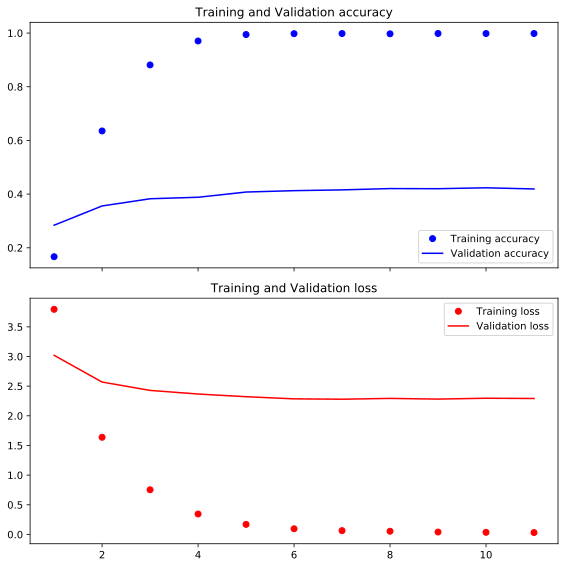

In [0]:
learning_curves(history)

Commentaire: d'après ce que nous montrent les courbes d'apprentissages, le modèle fort suceptible au sur-apprentissage, avec, par conséquent, une très mauvaise généralisation.

Évaluons-le tout de même sur le jeu de test, que le modèle n'a jamais rencontré.

In [0]:
# MODEL_NAME = 'vgg16_simple.h5'
vgg_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  model.evaluate_generator(test_generator, 
                           steps = test_generator.n)

print('Test accuracy: ', round(test_acc*100, 2))

Test accuracy:  41.25


### Méthodes de régularisation: Data Augmentation et Dropout

Nous décidons d'etoffer notre jeu de départ et d'ajouter du "bruit" au moyen de faibles transformations sur les images d'apprentissage (rotation, distortions, retournements…). Cette étape a pour but de permettre une meilleure généralisation de notre modèle en luttant contre le sur-apprentissage.

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = True,
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Aussi, dans le classifieur placé au dessus de notre base convolutive pré-entrainée de notre modèle, nous ajoutons une "couche" dite de Dropout, qui forcera les unités de sorties à prendre des décisions avec l'aide d'uniquement 50% des unités de la couche cachée. C'est une autre forme de régularisation.

In [0]:
vgg16_base = VGG16(include_top=False, 
                   weights='imagenet', 
                   input_shape=image_shape)

vgg_model = models.Sequential()
vgg_model.add(vgg16_base)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(n_classes, activation='softmax'))

vgg16_base.trainable = False

vgg_model.compile(optimizer=Adam(lr=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 51,628,152
Non-trainable params: 14,714,688
_________________________________________________________________


Nous entrainons à nouveau notre modèle et l'évaluons régulièrement à l'aide du jeu de validation pour empêcher tout sur-apprentissage.

In [0]:
# tbc = TensorBoardColab(graph_path="./vgg_graph_2")
MODEL_NAME = 'vgg16_regularized.h5'

callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = vgg_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 266s 3s/step - loss: 4.7381 - acc: 0.0288 - val_loss: 4.1582 - val_acc: 0.1068
Epoch 2/100
97/97 [==============================] - 231s 2s/step - loss: 4.2590 - acc: 0.0761 - val_loss: 3.5799 - val_acc: 0.1997
Epoch 3/100
97/97 [==============================] - 235s 2s/step - loss: 3.9179 - acc: 0.1198 - val_loss: 3.2000 - val_acc: 0.2559
Epoch 4/100
97/97 [==============================] - 235s 2s/step - loss: 3.6352 - acc: 0.1597 - val_loss: 2.9195 - val_acc: 0.3106
Epoch 5/100
97/97 [==============================] - 235s 2s/step - loss: 3.4297 - acc: 0.1966 - val_loss: 2.7231 - val_acc: 0.3379
Epoch 6/100
97/97 [==============================] - 237s 2s/step - loss: 3.2602 - acc: 0.2209 - val_loss: 2.5741 - val_acc: 0.3637
Epoch 7/100
97/97 [==============================] - 240s 2s/step - loss: 3.1341 - acc: 0.2384 - val_loss: 2.4820 - val_acc: 0.3719
Epoch 8/100
97/97 [==============================] - 239s 2s/step - loss: 2.

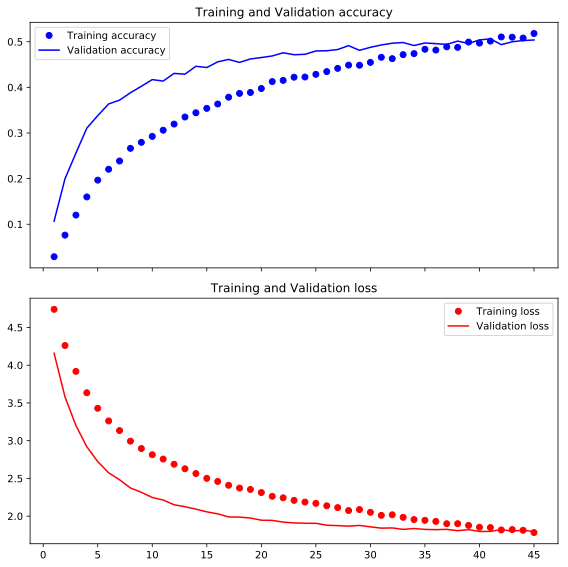

In [0]:
learning_curves(history, mult_ticks=5)

Commentaire: pas de sur-apprentissage cette fois. Un taux de généralisation légèrement plus important, qui évolue lentement mais sûrement avec chaque epoch d'apprentissage.

Évaluons ce modèle sur le jeu de test.

In [0]:
# MODEL_NAME = 'vgg16_regularized.h5'
vgg_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  vgg_model.evaluate_generator(test_generator, 
                               steps=test_generator.n)

print('\nTest accuracy: ', round(test_acc*100, 2))


Test accuracy:  49.25


### Fine-tuning

In [0]:
# MODEL_NAME = 'vgg16_regularized.h5'
# vgg_model = models.load_model(MODEL_NAME)

train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = True,
    preprocess_input = vgg16_preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Le but de cette phase est de modifier légèrement le modèle précédemment entrainé, en rendant les couches de la base convolutive entrainables. Précédemment, seul le classifieur au-dessus fut entrainé.

Nous procédons ainsi car, bien que la base convolutive fût entrainé sur un jeu de donnés riche qui permet une large généralisation dans la reconnaissance d'image (ImageNet), nous souhaitons maintenant ajusté les poids de cette base convolutive pour notre tache particulière.

In [0]:
vgg_model.layers[0].trainable = True
set_trainable = False

for layer in vgg_model.layers[0].layers:
  layer.trainable = True
  
  #print(layer.name, layer.trainable)

In [0]:
vgg_model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 66,342,840
Trainable params: 66,342,840
Non-trainable params: 0
_________________________________________________________________


Entrainons et évaluons le modèle.

In [0]:
# tbc = TensorBoardColab(graph_path="./vgg_graph_3")
MODEL_NAME = 'vgg16_tuned.h5'
callbacks = [
    EarlyStopping(patience=5, min_delta=0.005),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = vgg_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 460s 5s/step - loss: 1.7958 - acc: 0.5030 - val_loss: 1.0302 - val_acc: 0.7069
Epoch 2/100
97/97 [==============================] - 418s 4s/step - loss: 1.5810 - acc: 0.5514 - val_loss: 0.9677 - val_acc: 0.7244
Epoch 3/100
97/97 [==============================] - 424s 4s/step - loss: 1.5326 - acc: 0.5657 - val_loss: 0.9364 - val_acc: 0.7244
Epoch 4/100
97/97 [==============================] - 418s 4s/step - loss: 1.4506 - acc: 0.5843 - val_loss: 0.9529 - val_acc: 0.7261
Epoch 5/100
97/97 [==============================] - 420s 4s/step - loss: 1.4003 - acc: 0.5949 - val_loss: 0.9257 - val_acc: 0.7307
Epoch 6/100
97/97 [==============================] - 417s 4s/step - loss: 1.3248 - acc: 0.6144 - val_loss: 0.8981 - val_acc: 0.7412
Epoch 7/100
97/97 [==============================] - 416s 4s/step - loss: 1.3028 - acc: 0.6237 - val_loss: 0.8883 - val_acc: 0.7439
Epoch 8/100
97/97 [==============================] - 416s 4s/step - loss: 1.

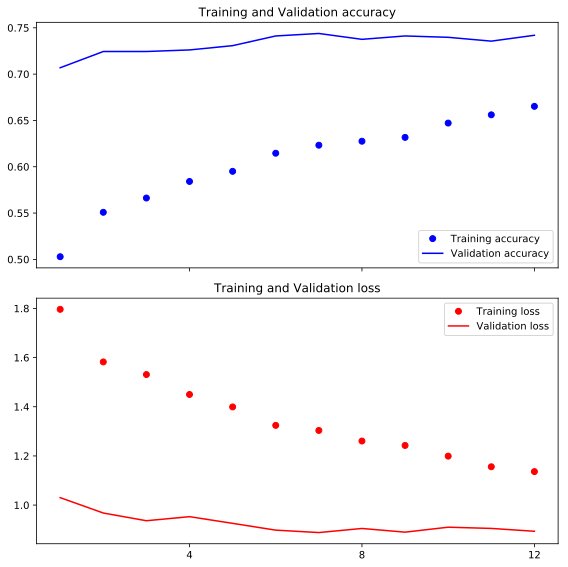

In [0]:
learning_curves(history, mult_ticks=4)

Commentaire: nous remarquons que notre modèle apprend et généralise beaucoup qu'à l'étape de régularisation précédente. 

Confirmons le en calculant son score de performance sur le jeu de test

In [0]:
# MODEL_NAME = 'vgg16_tuned.h5'
vgg_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  vgg_model.evaluate_generator(test_generator, 
                               steps=test_generator.n, 
                               verbose=0)

print('\nTest accuracy: ', round(test_acc*100, 2))


Test accuracy:  72.58


Calculons le poids du modèle et sauvegardons-le modèle sur notre espace de travail.

In [0]:
!du --block-size=M {MODEL_NAME}
!cp {MODEL_NAME} 'drive/My Drive/Projets Formation/Projet 7/models'

760M	vgg16_tuned.h5


## Modèle n°2: InceptionV3

Dans cette partie, nous suivons les mêmes étapes d'entrainement en utilisant un autre modèle, plus récent que le VGG16: Inception V3, dont voici l'architecture

![](https://i2.wp.com/sefiks.com/wp-content/uploads/2017/12/inception-v3-model.png?zoom=2&resize=760%2C283&ssl=1)



Bien que le InceptionV3 possède une architecture plus complexe, celle-ci permet l'usage de bien moins de paramètres à entrainer, et devient donc plus efficace en terme de calcul et de place occupée. Entrainons-le pour notre tâche.

### Pré-entrainement du classifieur

Définition des générateurs d'apprentissage, de validation et de test

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 299, 
    augmentation = True,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Chargement d'une nouvelle base convolutive: InceptionV3, entrainé sur les données ImageNet. 
Nous ajoutons par dessus un classifieur aléatoirement initialisé, avec une "couche" Dropout.

In [0]:
inceptionv3_base = InceptionV3(weights = 'imagenet', 
                               include_top = False,
                               input_shape = image_shape)
inceptionv3_base.trainable = False

inception_model = models.Sequential()
inception_model.add(inceptionv3_base)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(layers.Dense(2048, activation='relu'))
inception_model.add(layers.Dropout(0.5))
inception_model.add(layers.Dense(n_classes, activation='softmax'))

inception_model.compile(optimizer=Adam(lr=1e-4), 
                        loss='categorical_crossentropy', 
                        metrics=['acc'])

inception_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 26,245,016
Trainable params: 4,442,232
Non-trainable params: 21,802,784
_________________________________________________________________


Phase d'entrainement: nous observons l'évolution des mesures de performances pour sur le jeu d'apprentissage et de validation conjointement.

In [0]:
# tbc = TensorBoardColab(graph_path="./inception_graph_1")
MODEL_NAME = 'inceptionv3_regularized.h5'
callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = inception_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 426s 4s/step - loss: 3.8607 - acc: 0.2585 - val_loss: 1.8952 - val_acc: 0.8144
Epoch 2/100
97/97 [==============================] - 384s 4s/step - loss: 2.0788 - acc: 0.5694 - val_loss: 0.7033 - val_acc: 0.8577
Epoch 3/100
97/97 [==============================] - 386s 4s/step - loss: 1.4632 - acc: 0.6473 - val_loss: 0.4918 - val_acc: 0.8781
Epoch 4/100
97/97 [==============================] - 405s 4s/step - loss: 1.2701 - acc: 0.6761 - val_loss: 0.4195 - val_acc: 0.8864
Epoch 5/100
97/97 [==============================] - 409s 4s/step - loss: 1.1581 - acc: 0.6963 - val_loss: 0.3867 - val_acc: 0.8927
Epoch 6/100
97/97 [==============================] - 387s 4s/step - loss: 1.0934 - acc: 0.7053 - val_loss: 0.3714 - val_acc: 0.8857
Epoch 7/100
97/97 [==============================] - 382s 4s/step - loss: 1.0538 - acc: 0.7131 - val_loss: 0.3662 - val_acc: 0.8840
Epoch 8/100
97/97 [==============================] - 376s 4s/step - loss: 1.

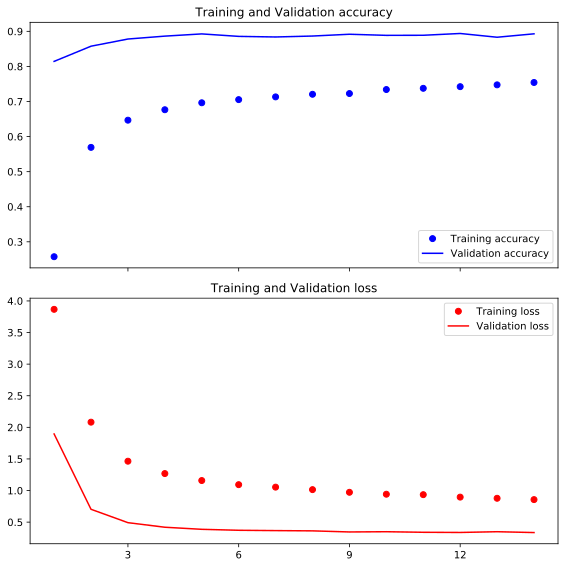

In [0]:
learning_curves(history, mult_ticks=3)

Commentaire: nous observons un net gain dans la performance d'apprentissage et de généralisation du modèle.

In [0]:
# MODEL_NAME = 'inceptionv3_regularized.h5'
inception_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  inception_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=0)

print('\nTest accuracy: ', round(test_acc*100, 2))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '



Test accuracy:  89.6


### Fine-tuning

Définition des générateurs d'apprentissage, de validation et de test

In [0]:
# MODEL_NAME = 'inceptionv3_regularized.h5'
# inception_model = models.load_model(MODEL_NAME)

train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 299, 
    augmentation = True,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Notre étape de *fine-tuning* se concentrera sur les les deux derniers modules d'inception, à partir de la 9e couche de concatenation. (voir schema InceptionV3)

In [0]:
inception_model.layers[0].trainable = True
set_trainable = False

for layer in inception_model.layers[0].layers:
  layer.trainable = set_trainable
  if layer.name == 'mixed8':
    set_trainable = True
  
# for layer in inception_model.layers[0].layers:
#   print(layer.name, layer.trainable)

In [0]:
inception_model.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy', 
                        metrics=['acc'])
inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 26,245,016
Trainable params: 15,557,112
Non-trainable params: 10,687,904
_________________________________________________________________


Phase d'entrainement: nous observons l'évolution des mesures de performances pour sur le jeu d'apprentissage et de validation conjointement.

In [0]:
# tbc = TensorBoardColab(graph_path="./inception_graph_2")
MODEL_NAME = 'inceptionv3_tuned.h5'
callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = inception_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 415s 4s/step - loss: 0.8674 - acc: 0.7518 - val_loss: 0.3966 - val_acc: 0.8755
Epoch 2/100
97/97 [==============================] - 373s 4s/step - loss: 0.7958 - acc: 0.7661 - val_loss: 0.3889 - val_acc: 0.8757
Epoch 3/100
97/97 [==============================] - 382s 4s/step - loss: 0.7400 - acc: 0.7827 - val_loss: 0.3822 - val_acc: 0.8755
Epoch 4/100
97/97 [==============================] - 382s 4s/step - loss: 0.7240 - acc: 0.7838 - val_loss: 0.3802 - val_acc: 0.8808
Epoch 5/100
97/97 [==============================] - 384s 4s/step - loss: 0.6869 - acc: 0.7947 - val_loss: 0.3773 - val_acc: 0.8793
Epoch 6/100
97/97 [==============================] - 383s 4s/step - loss: 0.6610 - acc: 0.8026 - val_loss: 0.3768 - val_acc: 0.8798
Epoch 7/100
97/97 [==============================] - 383s 4s/step - loss: 0.6360 - acc: 0.8079 - val_loss: 0.3745 - val_acc: 0.8786
Epoch 8/100
97/97 [==============================] - 382s 4s/step - loss: 0.

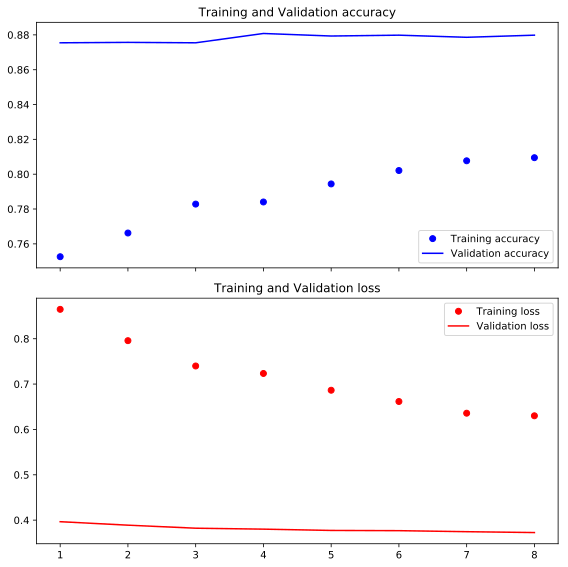

In [0]:
learning_curves(history, mult_ticks=1)

Commentaire: nous n'observons pas de gain de performance avec cette étape de *fine-tuning* cette fois-ci. Confirmons avec le jeu de test.

In [0]:
# MODEL_NAME = 'inceptionv3_tuned.h5'
inception_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  inception_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

4124/4124 [==============================] - 175s 42ms/step

Test accuracy:  88.48


Calculons la taille de ce modèle, et sauvegardons-le.

In [0]:
!du --block-size=M {MODEL_NAME}
!cp {MODEL_NAME} 'drive/My Drive/Projets Formation/Projet 7/models'

220M	inceptionv3_tuned.h5


## Modèle n°3: MobileNetV2

En dernier, nous essayons un modèle qui permet de faire un certain trade-off entre performance, nombre de calcul, et taille du modèle. Utilisons-le dans le cadre de notre application.

### Pré-entrainement du classifieur

Définition des générateurs d'apprentissage, de validation et de test. Attention, ici nous n'utilisons **pas** de méthode d'augmentation d'image. En effet, étant donné que ce modèle possède beaucoup moins de paramètres à faire apprendre, le risque de surapprentissage est moins grand.

In [0]:
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = False,
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Chargement et définition du modèle, et de ses paramètres d'apprentissage.

In [0]:
mobilenetV2_base = MobileNetV2(weights = 'imagenet', 
                               include_top = False,
                               input_shape = image_shape)
mobilenetV2_base.trainable = False

mobilenet_model = models.Sequential()
mobilenet_model.add(mobilenetV2_base)
mobilenet_model.add(layers.GlobalAveragePooling2D())
mobilenet_model.add(layers.Dense(512, activation = 'relu'))
mobilenet_model.add(layers.Dropout(0.5))
mobilenet_model.add(layers.Dense(n_classes, activation = 'softmax'))

mobilenet_model.compile(optimizer = Adam(1e-4),  
                        loss = 'categorical_crossentropy', 
                        metrics = ['acc'])

mobilenet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 2,975,416


Phase d'entrainement: nous observons l'évolution des mesures de performances pour sur le jeu d'apprentissage et de validation conjointement.

In [0]:
# tbc = TensorBoardColab(graph_path="./mobilenet_graph_1")
MODEL_NAME = 'mobilenetv2_regularized.h5'
callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = mobilenet_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs = 100, verbose = 1, callbacks = callbacks)

Epoch 1/100
97/97 [==============================] - 95s 975ms/step - loss: 4.6359 - acc: 0.0459 - val_loss: 3.9054 - val_acc: 0.2902
Epoch 2/100
97/97 [==============================] - 81s 836ms/step - loss: 3.7342 - acc: 0.2023 - val_loss: 2.6952 - val_acc: 0.5393
Epoch 3/100
97/97 [==============================] - 81s 836ms/step - loss: 2.8683 - acc: 0.3500 - val_loss: 1.8264 - val_acc: 0.6595
Epoch 4/100
97/97 [==============================] - 81s 832ms/step - loss: 2.2631 - acc: 0.4586 - val_loss: 1.3874 - val_acc: 0.6989
Epoch 5/100
97/97 [==============================] - 81s 838ms/step - loss: 1.9401 - acc: 0.5134 - val_loss: 1.1659 - val_acc: 0.7271
Epoch 6/100
97/97 [==============================] - 81s 839ms/step - loss: 1.7011 - acc: 0.5581 - val_loss: 1.0316 - val_acc: 0.7336
Epoch 7/100
97/97 [==============================] - 81s 831ms/step - loss: 1.5523 - acc: 0.5869 - val_loss: 0.9465 - val_acc: 0.7480
Epoch 8/100
97/97 [==============================] - 81s 833ms

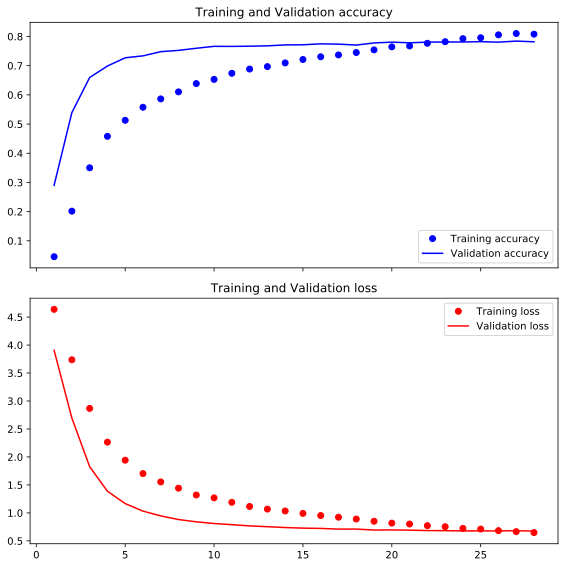

In [0]:
learning_curves(history, mult_ticks=5)

Commentaire: pas de sur-apprentissage observé, mais un taux de classification moins elevé que celui obtenu avec InceptionV3. Confirmons ce taux avec le jeu de test.

In [0]:
# MODEL_NAME = 'mobilenetv2_regularized.h5'
mobilenet_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  mobilenet_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


4124/4124 [==============================] - 75s 18ms/step

Test accuracy:  78.06


### Fine-tuning

Définition des générateurs d'apprentissage, de validation et de test. Toujours pas d'augmentation d'image pour le générateur d'images d'entrainement.

In [0]:
# MODEL_NAME = 'mobilenetv2_regularized.h5'
mobilenet_model = models.load_model(MODEL_NAME)
train_generator, valid_generator, test_generator =\
  create_generators(
    base_dir = 'data', 
    batch_size = 128, 
    side_length = 224, 
    augmentation = False,
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
)

image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
n_classes = train_generator.num_classes

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Pour tenter d'améliorer la performance obtenue en entrainant uniquement le classifieur par dessus le MobileNetV2, nous "dégelons" les couches supérieures la base convolutive et procédons à l'entrainement.

In [0]:
# mobilenet_model.layers[0].summary()

mobilenet_model.layers[0].trainable = True
set_trainable = False

for layer in mobilenet_model.layers[0].layers:
  if layer.name == 'block_10_expand':
    set_trainable = True
  layer.trainable = set_trainable
  

# for layer in mobilenet_model.layers[0].layers:
#   print(layer.name, layer.trainable)

In [0]:
mobilenet_model.compile(optimizer=Adam(lr=1e-5),
                        loss='categorical_crossentropy', 
                        metrics=['acc'])
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 2,975,416
Trainable params: 2,701,944
Non-trainable params: 273,472
_________________________________________________________________


In [0]:
# tbc = TensorBoardColab(graph_path="./mobilenet_graph_2")
MODEL_NAME = 'mobilenetv2_tuned.h5'
callbacks = [
    EarlyStopping(patience=5, min_delta=0.01),
    ModelCheckpoint(MODEL_NAME, save_best_only=True),
    # TensorBoardColabCallback(tbc),
]

history = mobilenet_model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = np.ceil(train_generator.n/batch_size),  
    validation_data = valid_generator, 
    validation_steps = np.ceil(valid_generator.n/batch_size),
    epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
97/97 [==============================] - 103s 1s/step - loss: 0.8379 - acc: 0.7553 - val_loss: 0.5022 - val_acc: 0.8655
Epoch 2/100
97/97 [==============================] - 84s 867ms/step - loss: 0.7522 - acc: 0.7775 - val_loss: 0.4867 - val_acc: 0.8667
Epoch 3/100
97/97 [==============================] - 85s 880ms/step - loss: 0.6859 - acc: 0.7966 - val_loss: 0.4782 - val_acc: 0.8667
Epoch 4/100
97/97 [==============================] - 85s 876ms/step - loss: 0.6493 - acc: 0.8025 - val_loss: 0.4731 - val_acc: 0.8635
Epoch 5/100
97/97 [==============================] - 85s 875ms/step - loss: 0.6120 - acc: 0.8158 - val_loss: 0.4675 - val_acc: 0.8638
Epoch 6/100
97/97 [==============================] - 85s 875ms/step - loss: 0.5757 - acc: 0.8257 - val_loss: 0.4642 - val_acc: 0.8648
Epoch 7/100
97/97 [==============================] - 85s 877ms/step - loss: 0.5356 - acc: 0.8390 - val_loss: 0.4610 - val_acc: 0.8640
Epoch 8/100
97/97 [==============================] - 84s 868ms/s

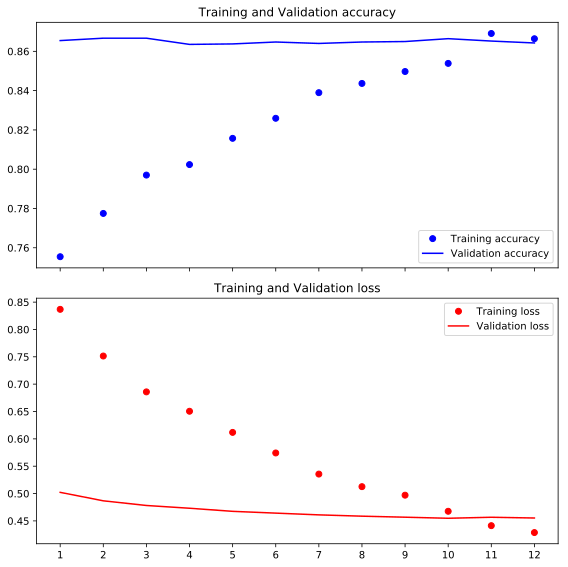

In [0]:
learning_curves(history, mult_ticks=1)

Commentaire: cette fois-ci, le *fine-tuning* nous permet d'augmenter nettement la performance du modèle (de 78% à plus de 84%)

In [0]:
# MODEL_NAME = 'mobilenetv2_tuned.h5'
mobilenet_model = models.load_model(MODEL_NAME)

test_loss, test_acc =\
  mobilenet_model.evaluate_generator(test_generator, 
                                     steps=test_generator.n, 
                                     verbose=1)

print('\nTest accuracy: ', round(test_acc*100, 2))

4124/4124 [==============================] - 67s 16ms/step

Test accuracy:  84.63


Enfin, calculons la taille du modèle et sauvegardons-le.

In [0]:
!du --block-size=M {MODEL_NAME}
!cp {MODEL_NAME} 'drive/My Drive/Projets Formation/Projet 7/models'

33M	mobilenetv2_tuned.h5


## Conclusion

Comparons maintenant les 3 modèles que nous avons entrainés sur trois critères:
- Performance: taux de généralisation
- Espace de disque occupé
- Nombre de paramètres total

|    **Modèle**   | Performance (%) | Taille (Mo) | # de paramètres (millions) |
|:-----------:|:---------------:|:-----------:|:--------------------------:|
| **VGG16**       |       72.5      |     760     |            66.3            |
| **InceptionV3** |       89.5      |     220     |            26.2            |
| **MobileNetV2** |       84.5      |      33     |              3             |

Definissons à nouveau un générateur, cette fois-ci qui lira des entrées de telle manière à pouvoir être traité par notre modèle le plus performant: InceptionV3

In [5]:
_, _, inception_generator =\
  create_generators(
    base_dir = 'data', batch_size = 1, side_length = 299,
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
)

Found 12345 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4124 images belonging to 120 classes.


Chargeons le modèle

In [6]:
MODEL_NAME = 'inceptionv3_regularized.h5'

!cp 'drive/My Drive/Projets Formation/Projet 7/models/{MODEL_NAME}' .
inception_model = models.load_model(MODEL_NAME)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Sauvegardons le dictionnaire qui permet d'encoder chaque classe cible en un entier. Il nous sera utile pour notre *standalone* script qui permettra de faire des inférences à partir de n'importe quelle image fournie. 

In [0]:
DICT_NAME = 'class_traductor_120.pkl'

with open(DICT_NAME, 'wb') as f:
    pickle.dump(inception_generator.class_indices, f)

!cp {DICT_NAME} 'drive/My Drive/Projets Formation/Projet 7/'

### Analyse des erreurs

Dans cette dernière partie, nous nous intéresserons à l'analyse des erreurs faites par le modèle, en essayant de livrer des pistes de diagnostic.

Phase d'inférence: calculons les probabilités qu'on chacune des images du jeu de test d'appartenir à une des 120 classes, et servons-nous en pour en déduire les classes les plus probables.

In [7]:
inception_probas = inception_model.predict_generator(inception_generator, 
                                                     steps=inception_generator.n, 
                                                     verbose=1)
inception_predictions = np.argmax(inception_probas, axis=1)

4124/4124 [==============================] - 175s 42ms/step


Avec l'aide du `classification_report` de `scikit-learn`, calculons pour chacune des classes cibles trois mesures de performance sur le jeu d'inférence:
- f1 score
- précision
- rappel

Nous nous servirons du f1 score comme référence de qualité de la classification. Sur chaque classe, étant donné qu'il est une moyenne harmonique des deux autres métriques (la valeur de support correspond au nombre d'images sur lesquelles sont basées nos estimations par classes)

In [8]:
# recupérer noms des classes et étiquette de toutes les images
true_labels = inception_generator.classes
class_names = (list(inception_generator.class_indices.keys()))

df_report = make_report(true_labels, inception_predictions, class_names)
df_report.sort_values(by='f1-score')

,f1-score,precision,recall,support
Eskimo_Dog,0.37,0.62,0.27,30.0
Walker_Hound,0.68,0.66,0.70,30.0
Collie,0.69,0.82,0.60,30.0
Miniature_Poodle,0.72,0.67,0.77,31.0
Toy_Poodle,0.72,0.83,0.63,30.0
English_Foxhound,0.75,0.88,0.66,32.0
Siberian_Husky,0.75,0.65,0.90,39.0
Rhodesian_Ridgeback,0.76,0.86,0.69,35.0
Staffordshire_Bullterrier,0.78,0.82,0.74,31.0
Appenzeller,0.79,0.76,0.83,30.0


Nous remarquons que notre modèle a particulièrement du mal à prédire justement la classe des photos `Eskimo_Dog`.

Regardons quelles sont les labels les plus souvents prédits pour les images appartenant à cette classe.

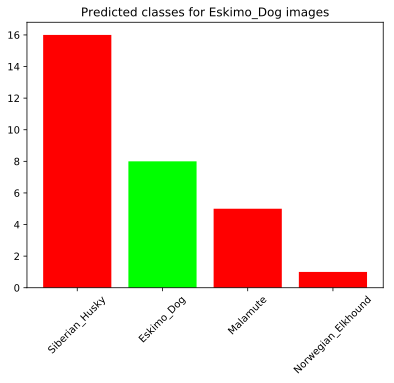

In [9]:
class_analysis('Eskimo_Dog', inception_generator, 
               inception_probas, inception_predictions)

Il semble que la frontière entre les classes `Siberian_Husky`et `Eskimo_Dog` soit poreuse.

Affichons les images où le classfieur a fait les erreurs les plus larges, en terme de probabilités, sur cette classe

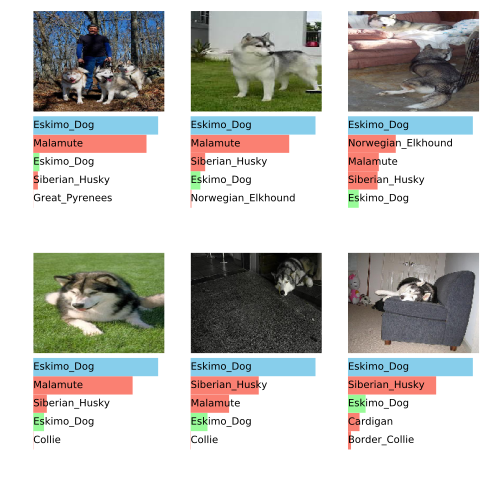

In [10]:
instance_analysis('Eskimo_Dog', inception_generator, 
                  inception_probas, inception_predictions)

En se servant des métriques de performances pour indentifier clairement les classes sur lesquelles le classifieur commet le plus d'erreur, nous permet d'éventuellement diagonistiquer l'origine de ces fautes:
- qualité d'image
- trop de catégories qui mériteraient d'être regroupées
- erreur d'étiquetage du jeu de données initial